# Introduction to Hiddem Markov Models - Blackarbs

http://www.blackarbs.com/blog/introduction-hidden-markov-models-python-networkx-sklearn/2/9/2017

In [4]:
import pandas as pd
import pandas_datareader.data as web
import sklearn.mixture as mix

import numpy as np
import scipy.stats as scs

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
%matplotlib inline

import seaborn as sns
import missingno as msno
from tqdm import tqdm
p=print

/var/folders/fd/kt7pqpg95nl34mn9pl8k173c0000gn/T/ipykernel_2796/4128946114.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end = pd.datetime.today()


            TEDRATE  T10Y2Y  T10Y3M        SPY      sret
2002-01-03     0.18    1.97    3.43  79.634224  0.011275
2002-01-04     0.18    1.99    3.46  80.165855  0.006654
2002-01-07     0.21    2.01    3.41  79.600166 -0.007081
2002-01-08     0.19    2.03    3.42  79.416100 -0.002315
2002-01-09     0.19    2.07    3.42  78.768646 -0.008186


<AxesSubplot:>

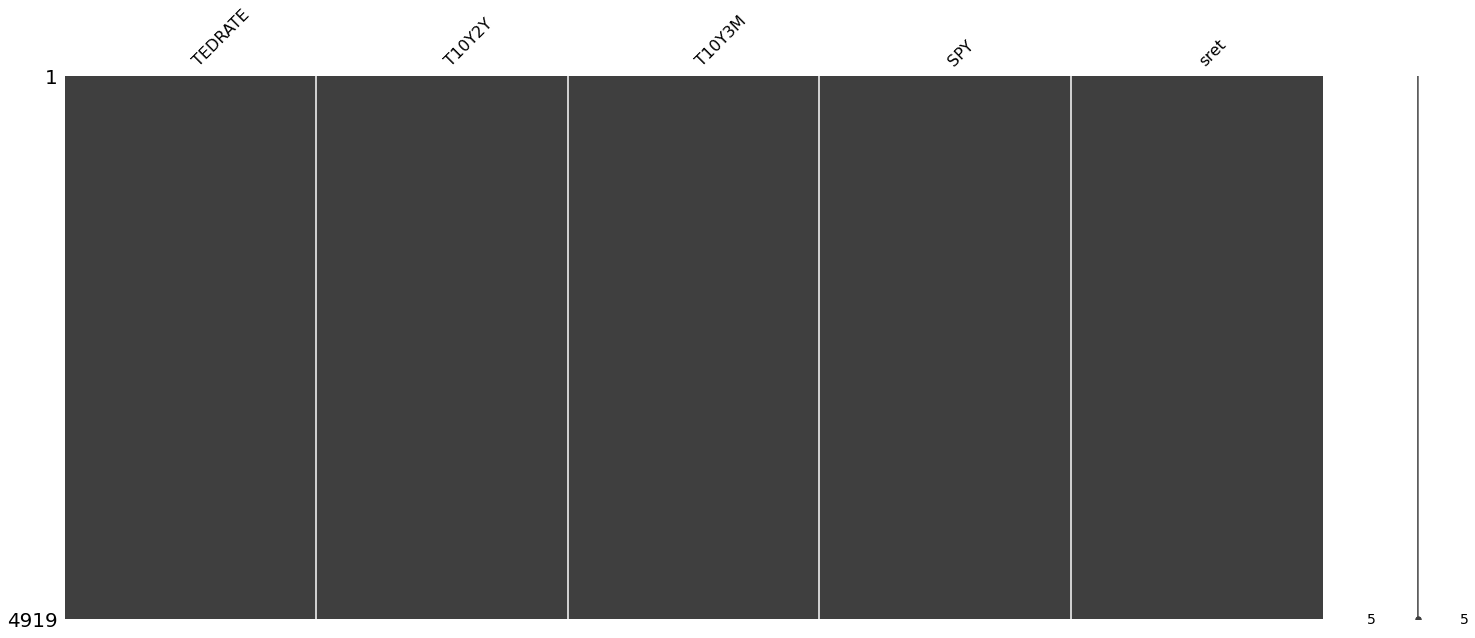

In [5]:
# get fed data

f1 = 'TEDRATE' # ted spread
f2 = 'T10Y2Y' # constant maturity ten yer - 2 year
f3 = 'T10Y3M' # constant maturity 10yr - 3m

start = pd.to_datetime('2002-01-01')
end = pd.datetime.today()

mkt = 'SPY'
MKT = (web.DataReader([mkt], 'yahoo', start, end)['Adj Close']
       .rename(columns={mkt:mkt})
       .assign(sret=lambda x: np.log(x[mkt]/x[mkt].shift(1)))
       .dropna())

data = (web.DataReader([f1, f2, f3], 'fred', start, end)
        .join(MKT, how='inner')
        .dropna()
       )

p(data.head())

# gives us a quick visual inspection of the data
msno.matrix(data)

In [7]:
data

TEDRATE  T10Y2Y  T10Y3M         SPY      sret
2002-01-03     0.18    1.97    3.43   79.634224  0.011275
2002-01-04     0.18    1.99    3.46   80.165855  0.006654
2002-01-07     0.21    2.01    3.41   79.600166 -0.007081
2002-01-08     0.19    2.03    3.42   79.416100 -0.002315
2002-01-09     0.19    2.07    3.42   78.768646 -0.008186
...             ...     ...     ...         ...       ...
2022-01-14     0.11    0.79    1.65  464.720001  0.000409
2022-01-18     0.08    0.81    1.71  456.489990 -0.017868
2022-01-19     0.09    0.79    1.66  451.750000 -0.010438
2022-01-20     0.08    0.75    1.66  446.750000 -0.011130
2022-01-21     0.09    0.74    1.58  437.980011 -0.019826

[4919 rows x 5 columns]

Means and vars of each hidden state
0th hidden state
mean =  [2.25086558e-01 2.04890892e+00 2.63007931e+00 4.37996991e-04]
var =  [3.91438678e-03 2.19060171e-01 4.02046566e-01 8.92091858e-05]

1th hidden state
mean =  [0.33979544 0.53638132 0.80381942 0.00095597]
var =  [2.27922174e-02 2.07413460e-01 5.13214919e-01 4.86792404e-05]

2th hidden state
mean =  [ 1.01493646  1.48071121  1.91291352 -0.00192152]
var =  [5.18046534e-01 4.24401421e-01 9.04472270e-01 5.58989307e-04]



findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.
findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.


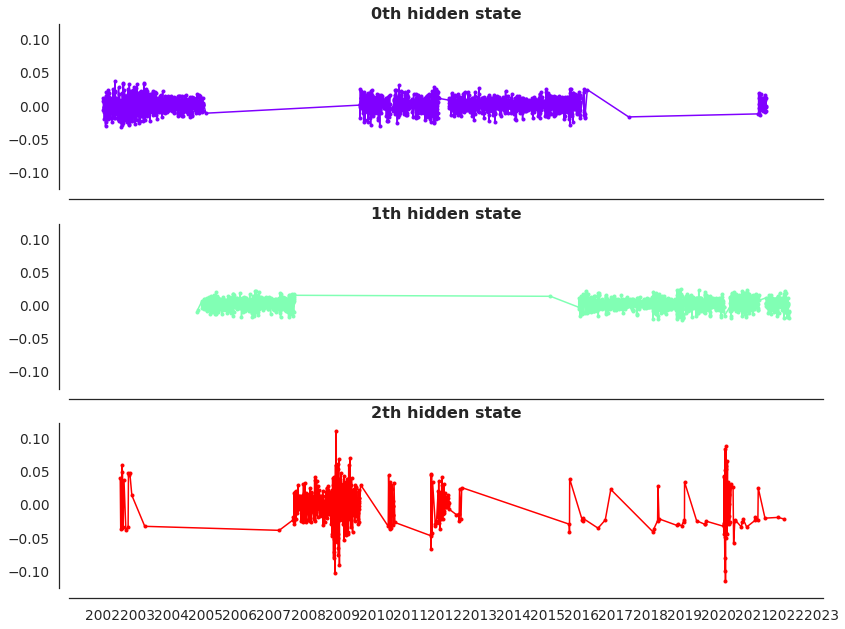

In [9]:
# code adapted from http://hmmlearn.readthedocs.io
# for sklearn 18.1

col = 'sret'
select = data.iloc[:].dropna()

ft_cols = [f1, f2, f3, 'sret']
X = select[ft_cols].values

model = mix.GaussianMixture(n_components=3, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=7).fit(X)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covariances_[i]))
    print()

sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'font.family':u'courier prime code', 'legend.frameon': True}
sns.set_style('white', style_kwds)

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(12,9))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, color) in enumerate(zip(axs, colors)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(select.index.values[mask],
                 select[col].values[mask],
                 ".-", c=color)
    ax.set_title("{0}th hidden state".format(i), fontsize=16, fontweight='demi')

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    sns.despine(offset=10)

plt.tight_layout()
fig.savefig('Hidden Markov (Mixture) Model_Regime Subplots.png')

In [11]:
color

array([1.0000000e+00, 1.2246468e-16, 6.1232340e-17, 1.0000000e+00])

/Users/NicholasMac/Documents/Quant/pyFi/lib/python3.8/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.


        Date  states  TEDRATE  T10Y2Y  T10Y3M        SPY      sret  mkt_cret
0 2002-01-03       0     0.18    1.97    3.43  79.634224  0.011275  0.011275
1 2002-01-04       0     0.18    1.99    3.46  80.165855  0.006654  0.017929
2 2002-01-07       0     0.21    2.01    3.41  79.600166 -0.007081  0.010848
3 2002-01-08       0     0.19    2.03    3.42  79.416100 -0.002315  0.008533
4 2002-01-09       0     0.19    2.07    3.42  78.768646 -0.008186  0.000347


findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.
findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.


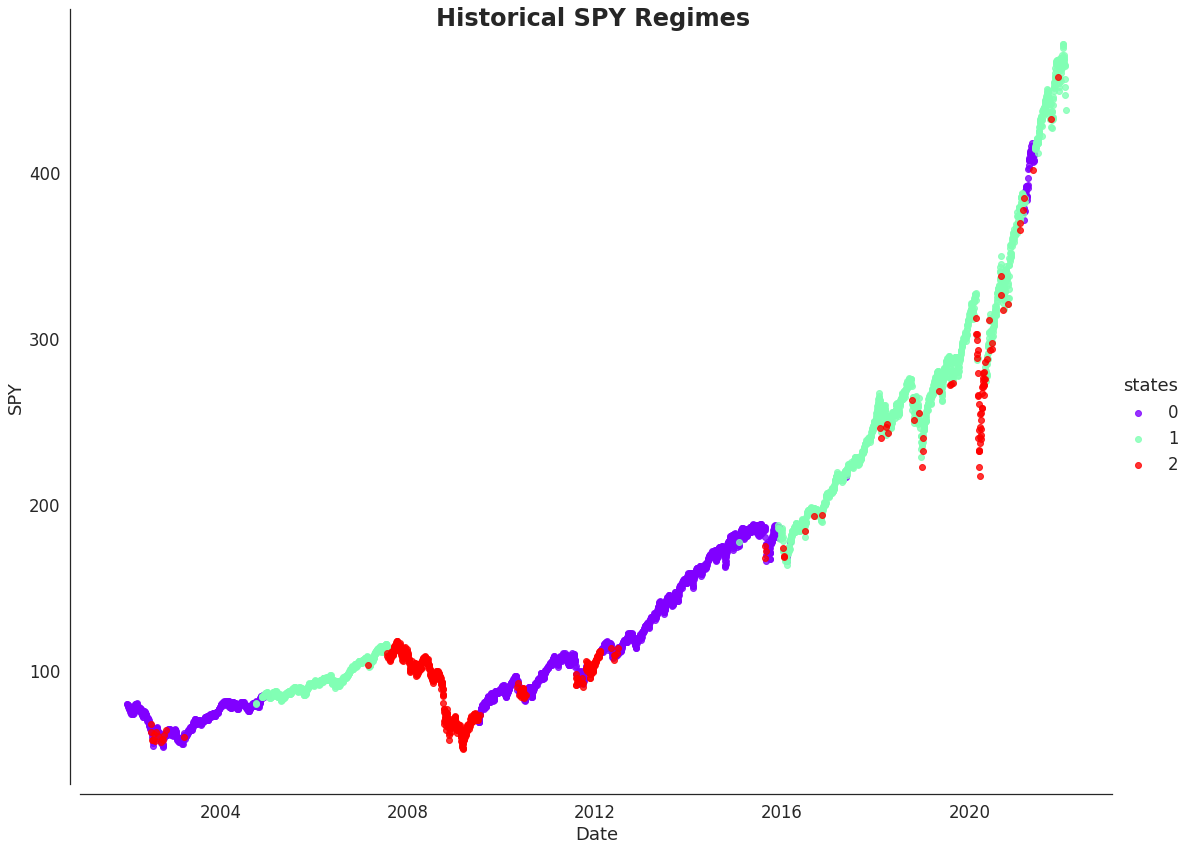

In [13]:
sns.set(font_scale=1.5)
states = (pd.DataFrame(hidden_states, columns=['states'], index=select.index)
          .join(select, how='inner')
          .assign(mkt_cret=select.sret.cumsum())
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
p(states.head())

sns.set_style('white', style_kwds)
order = [0, 1, 2]
fg = sns.FacetGrid(data=states, hue='states', hue_order=order,
                   palette=colors, aspect=1.31, size=12)
fg.map(plt.scatter, 'Date', mkt, alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle('Historical SPY Regimes', fontsize=24, fontweight='demi')
fg.savefig('Hidden Markov (Mixture) Model_SPY Regimes.png')